### Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import json

# to ignore the warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# importing the dataset

products = pd.read_csv('./dataset/products.csv')
order_train = pd.read_csv('./dataset/order_products__train.csv')
orders = pd.read_csv('./dataset/orders.csv')
aisles = pd.read_csv('./dataset/aisles.csv')
deps = pd.read_csv('./dataset/departments.csv')

In [3]:
print("Products table")
display(products.head(2))
print("Orders table")
display(orders.head(2))
print("Aisles table")
display(aisles.head(2))
print("Departments table")
display(deps.head(2))

Products table


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


Orders table


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


Aisles table


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


Departments table


,department_id,department
0,1,frozen
1,2,other


#### As we can observe that it will be hard to maintain all the 4 tables we try to merge all that in orders table and drop some columns which are not important

In [4]:
# merging the aisle description with the products
df = pd.merge(aisles, products, how="inner", on="aisle_id")
# merging the department details with the merged table
df = pd.merge(deps, df, how='inner', on='department_id')
# merging the orders table to get the order details like product details and all
df = pd.merge(order_train, df, how='inner', on='product_id')
# merging the orders table which contains user_id and all
df = pd.merge(orders, df, how='inner', on='order_id')
df.shape

(1384617, 15)

In [5]:
# droping the irrevalant columns
df = df.drop(['aisle_id','department_id','eval_set','order_number'],axis=1)
df.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department,aisle,product_name
0,1187899,1,4,8,14.0,49235,10,1,dairy eggs,cream,Organic Half & Half
1,1187899,1,4,8,14.0,46149,11,1,beverages,soft drinks,Zero Calorie Cola
2,1187899,1,4,8,14.0,196,1,1,beverages,soft drinks,Soda
3,1187899,1,4,8,14.0,27845,9,0,dairy eggs,milk,Organic Whole Milk
4,1187899,1,4,8,14.0,38928,3,1,dairy eggs,yogurt,0% Greek Strained Yogurt


## Data exploration

In [6]:
# checking the data type and count of rows in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int64  
 1   user_id                 1384617 non-null  int64  
 2   order_dow               1384617 non-null  int64  
 3   order_hour_of_day       1384617 non-null  int64  
 4   days_since_prior_order  1384617 non-null  float64
 5   product_id              1384617 non-null  int64  
 6   add_to_cart_order       1384617 non-null  int64  
 7   reordered               1384617 non-null  int64  
 8   department              1384617 non-null  object 
 9   aisle                   1384617 non-null  object 
 10  product_name            1384617 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 126.8+ MB


In [7]:
# checking the stats of the columns
display(df.describe())

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,1.031128e+05,2.701392e+00,1.357759e+01,1.706613e+01,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,5.948715e+04,2.167646e+00,4.238458e+00,1.042642e+01,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,5.173200e+04,1.000000e+00,1.000000e+01,7.000000e+00,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,1.029330e+05,3.000000e+00,1.400000e+01,1.500000e+01,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,1.549590e+05,5.000000e+00,1.700000e+01,3.000000e+01,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,2.062090e+05,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,8.000000e+01,1.000000e+00


In [8]:
# checking if there exists any null value
df.isna().sum()

order_id                  0
user_id                   0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department                0
aisle                     0
product_name              0
dtype: int64

#### Lets see top 20 ordered products

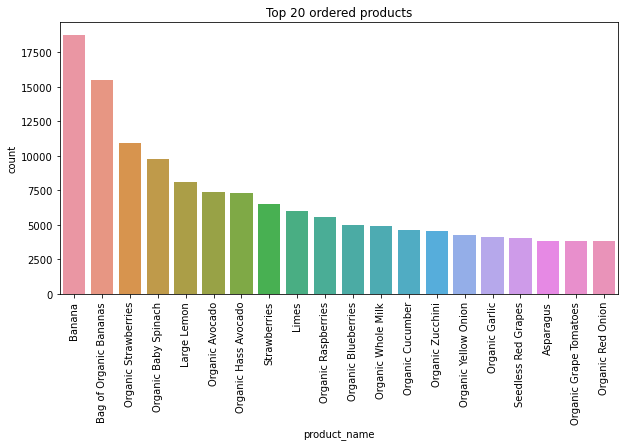

In [9]:
# setting the figure size for all
plt.rcParams['figure.figsize'] = [10,5]

sns.countplot(df.product_name, order=df.product_name.value_counts().index[:20]) #[:20] to get top 20 only
plt.title('Top 20 ordered products')
plt.xticks(rotation=90)
plt.show()

#### Top 10 categories and subcategories

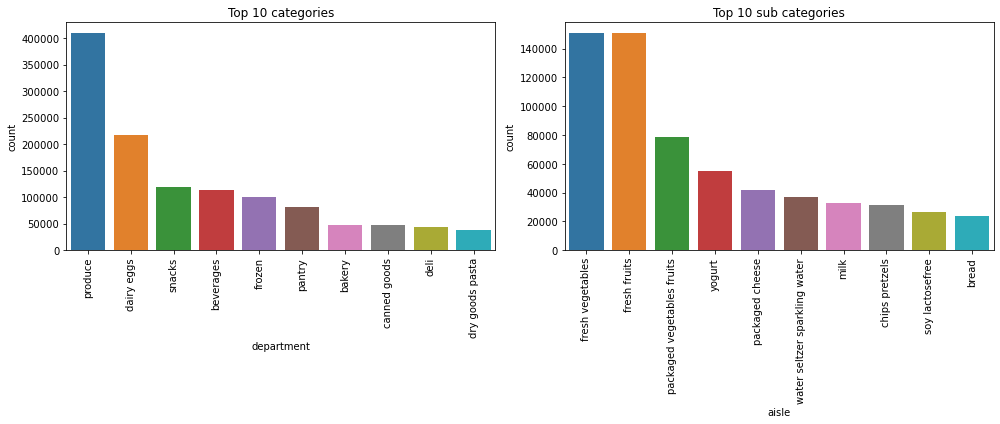

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(df.department, order=df.department.value_counts().index[:10],  ax=axes[0]) #[:10] to get top 10 only
axes[0].set_title('Top 10 categories')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(df.aisle, order=df.aisle.value_counts().index[:10],  ax=axes[1]) #[:10] to get top 10 only
axes[1].set_title('Top 10 sub categories')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### As we can observe that fresh foods, fruits is the highest ordered in the whole data


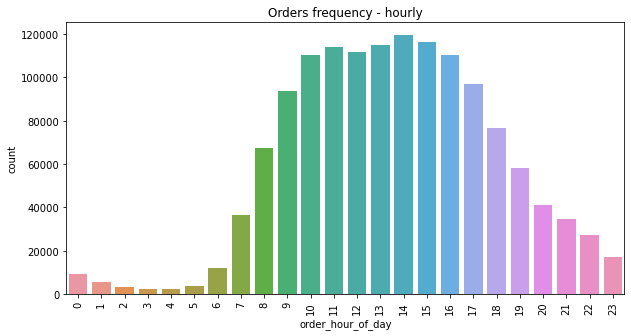

In [11]:
# checking the time when orders are at their peak
sns.countplot(df.order_hour_of_day)
plt.title('Orders frequency - hourly')
plt.xticks(rotation=90)
plt.show()

# it can be observed the peak time is between 10 am - 4 pm

## Model building

In [12]:
# getting the top 100 products only because if we keep all the products it need 50 gb space which is not possible
top_100_product_names = df['product_name'].value_counts().index[:100]
filtered_df = df[df['product_name'].isin(top_100_product_names)]
# filtered_df.head()

In [14]:
# to get the id associated with the product name


filtered_df = df[df['product_name'].isin(top_100_product_names)]
result = filtered_df[['product_id', 'product_name']].drop_duplicates()
# print(result)

# converting the top products to json file
result_list = result.to_dict(orient='records')
with open('./app/product_id_names.json', 'w') as json_file:
    json.dump(result_list, json_file)

In [15]:
# converting the data to make it suitable for apriori algorithm

basket = pd.get_dummies(filtered_df, columns=['product_id'], prefix='', prefix_sep='')
basket = basket.groupby('order_id').max()
basket.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,department,aisle,product_name,196,...,46667,46906,46979,47144,47209,47626,47766,48679,49235,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,112108,4,10,9.0,8,1,produce,packaged cheese,Organic Whole String Cheese,0,...,0,0,0,0,1,0,0,0,0,1
36,79431,6,18,30.0,8,1,produce,water seltzer sparkling water,Spring Water,0,...,0,0,1,0,0,0,0,1,1,0
38,42756,6,16,24.0,7,1,produce,packaged vegetables fruits,Organic Baby Arugula,0,...,0,0,0,0,0,0,0,0,0,0
96,17227,6,20,30.0,7,1,produce,packaged vegetables fruits,Organic Raspberries,0,...,0,0,0,0,0,0,0,0,0,0
98,56463,3,8,14.0,39,1,produce,soy lactosefree,Uncured Genoa Salami,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
basket.shape

(94185, 109)

In [17]:
# droping the unrequired columns

up_basket = basket.drop(['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order',
                                 'reordered', 'department', 'aisle', 'product_name'], axis=1)
up_basket.head()

,196,4605,4920,5025,5077,5450,5785,5876,6184,8174,...,46667,46906,46979,47144,47209,47626,47766,48679,49235,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
36,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Finding the apriori rules


In [18]:
frequent_itemsets = apriori(up_basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24852),(4605),0.198821,0.039943,0.011371,0.057193,1.431883,0.003430,1.018297,0.376469
1,(4605),(24852),0.039943,0.198821,0.011371,0.284689,1.431883,0.003430,1.120042,0.314167
2,(24852),(4920),0.198821,0.043096,0.012337,0.062053,1.439872,0.003769,1.020211,0.381305
3,(4920),(24852),0.043096,0.198821,0.012337,0.286277,1.439872,0.003769,1.122535,0.319252
4,(5876),(13176),0.037214,0.164357,0.011329,0.304422,1.852197,0.005212,1.201365,0.477885
...,...,...,...,...,...,...,...,...,...,...
73,(26209),(47766),0.064055,0.078664,0.011010,0.171888,2.185081,0.005971,1.112574,0.579469
74,(27966),(47209),0.058884,0.077433,0.010819,0.183736,2.372848,0.006260,1.130232,0.614765
75,(47209),(27966),0.077433,0.058884,0.010819,0.139723,2.372848,0.006260,1.093968,0.627125
76,(47766),(47626),0.078664,0.086373,0.014323,0.182076,2.108029,0.007528,1.117008,0.570501


### Some of the assoication rules

In [19]:
sorted_rules = rules.sort_values(by="lift", ascending=False)

# Filter and display the top rules based on positive correlation i.e lift > 1
top_rules = sorted_rules[sorted_rules['lift'] > 1.0]
display(top_rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
69,(26209),(31717),0.064055,0.037437,0.010692,0.166915,4.458570,0.008294,1.155420,0.828802
68,(31717),(26209),0.037437,0.064055,0.010692,0.285593,4.458570,0.008294,1.310100,0.805883
71,(26209),(47626),0.064055,0.086373,0.016935,0.264379,3.060917,0.011402,1.241982,0.719380
70,(47626),(26209),0.086373,0.064055,0.016935,0.196066,3.060917,0.011402,1.164207,0.736953
34,(21137),(27966),0.115666,0.058884,0.017731,0.153295,2.603341,0.010920,1.111504,0.696432
...,...,...,...,...,...,...,...,...,...,...
58,(24852),(27845),0.198821,0.052110,0.011085,0.055751,1.069874,0.000724,1.003856,0.081518
47,(21903),(24852),0.103881,0.198821,0.021235,0.204415,1.028135,0.000581,1.007031,0.030538
46,(24852),(21903),0.198821,0.103881,0.021235,0.106803,1.028135,0.000581,1.003272,0.034156
31,(21137),(24852),0.115666,0.198821,0.023082,0.199559,1.003711,0.000085,1.000922,0.004181


In [23]:
result_list = top_rules.to_dict(orient='records')

json_string = pd.Series(result_list).to_json(orient='records')

with open('./app/top_rules.json', 'w') as json_file:
    json_file.write(json_string)

In [ ]:
print("Total rules available: ", len(top_rules))